# Analyse exploratoire de données

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso

In [2]:
pd.set_option("display.max_columns", 40)

# Exemple 1: analyse de données en vue d'une application de recommandation de produits alimentaires.

## Contexte:

On veut créer une application mobile permettant à un consommateur de savoir si le produit qu'il compte acheter est conforme à son régime alimentaire et qui lui propose si possible un meilleur produit.

En pratique:

* L'utilisateur défini son profil de consommateur parmi un ensemble de profils prédéfinis (par exemple: je recherche des produits avec un bon nutri-score et sans additifs).

* L'application lui indique si le produit qu'il scanne est conforme à son profil.

* L'application lui propose éventuellement un produit de substitution meilleur.

<img src="appli.png" width="300" height="500">

Il faut disposer d'une base de données comportant des informations sur les produits susceptibles d'être scannés et il faut que ces informations soit pertinantes.

Voici les données dont nous nous servirons pour ce premier exemple:

In [3]:
data = pd.read_csv("data/foodfacts.csv", low_memory=False)

In [4]:
data.shape

(320772, 38)

In [5]:
data.head()

,code,product_name,origins,labels,ingredients_text,allergens,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,categorie,sous_categorie,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,28 g (1 ONZ),0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,0.0,d,NaN,NaN,2243.0,28.57,28.57,NaN,NaN,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,NaN,0.000,0.00129,14.0
2,0000000004559,Peanuts,NaN,NaN,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,0.0,b,NaN,NaN,1941.0,17.86,0.00,NaN,NaN,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,NaN,0.071,0.00129,0.0
3,0000000016087,Organic Salted Nut Mix,NaN,NaN,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,28 g (0.25 cup),0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,0.0,d,NaN,NaN,2540.0,57.14,5.36,NaN,NaN,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,NaN,0.143,0.00514,12.0
4,0000000016094,Organic Polenta,NaN,NaN,Organic polenta,NaN,NaN,NaN,NaN,35 g (0.25 cup),0.0,[ organic-polenta -> en:organic-polenta ] [...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1552.0,1.43,NaN,NaN,NaN,NaN,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Etape 1: néttoyage des données

## Etape 1.1: gérer le manque grossier de données

### Visualisation des valeurs manquantes

<AxesSubplot:>

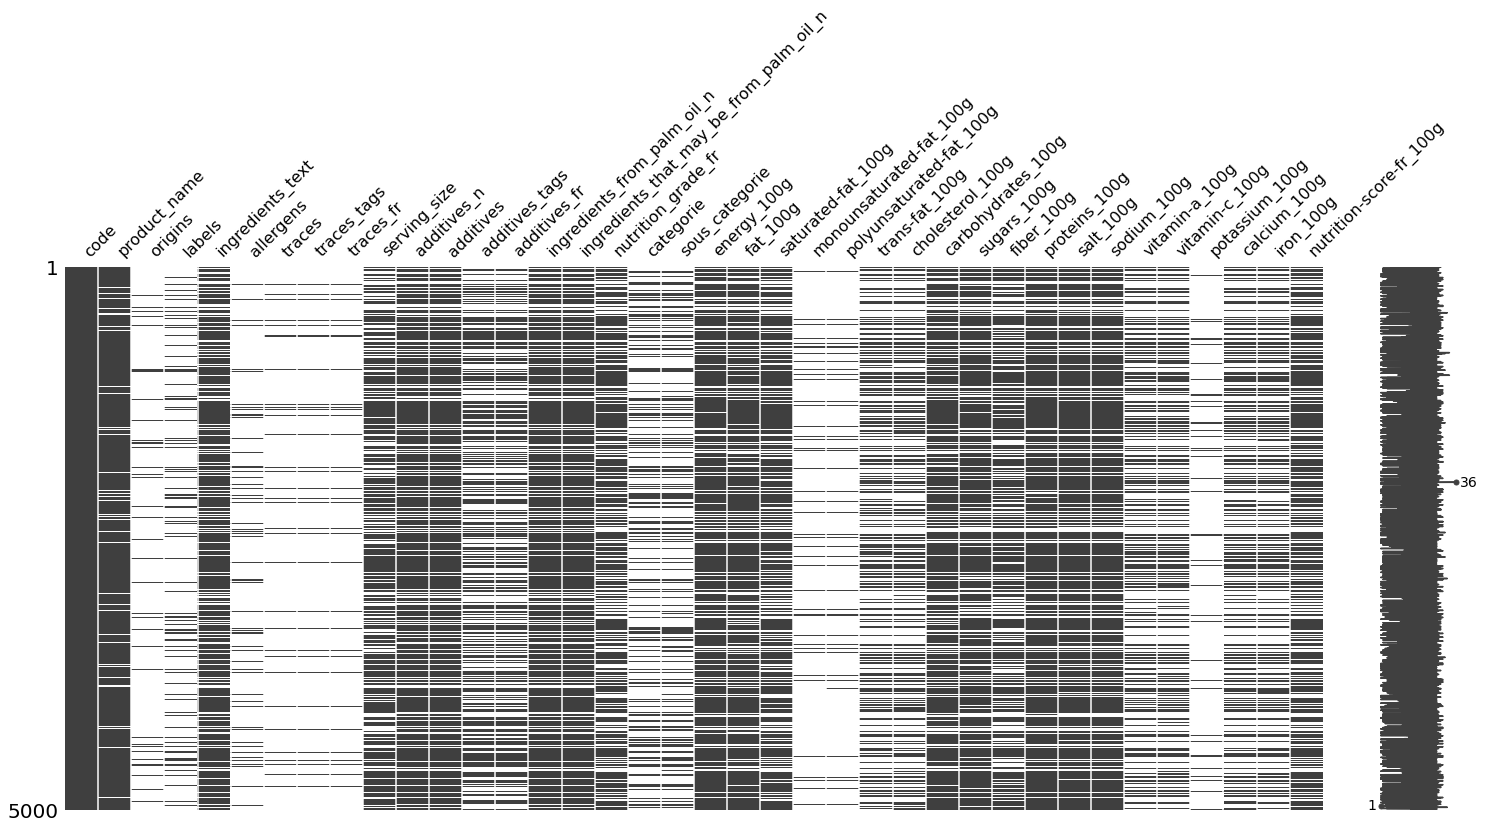

In [6]:
mso.matrix(data.sample(5000))
# Les cases remplies sont en noire, les cases vides en blanc.

On voit que certaines colonnes sont quasiment vides, on ne pourra donc rien en faire. On remarque également certaines lignes quasiment vides.

<AxesSubplot:>

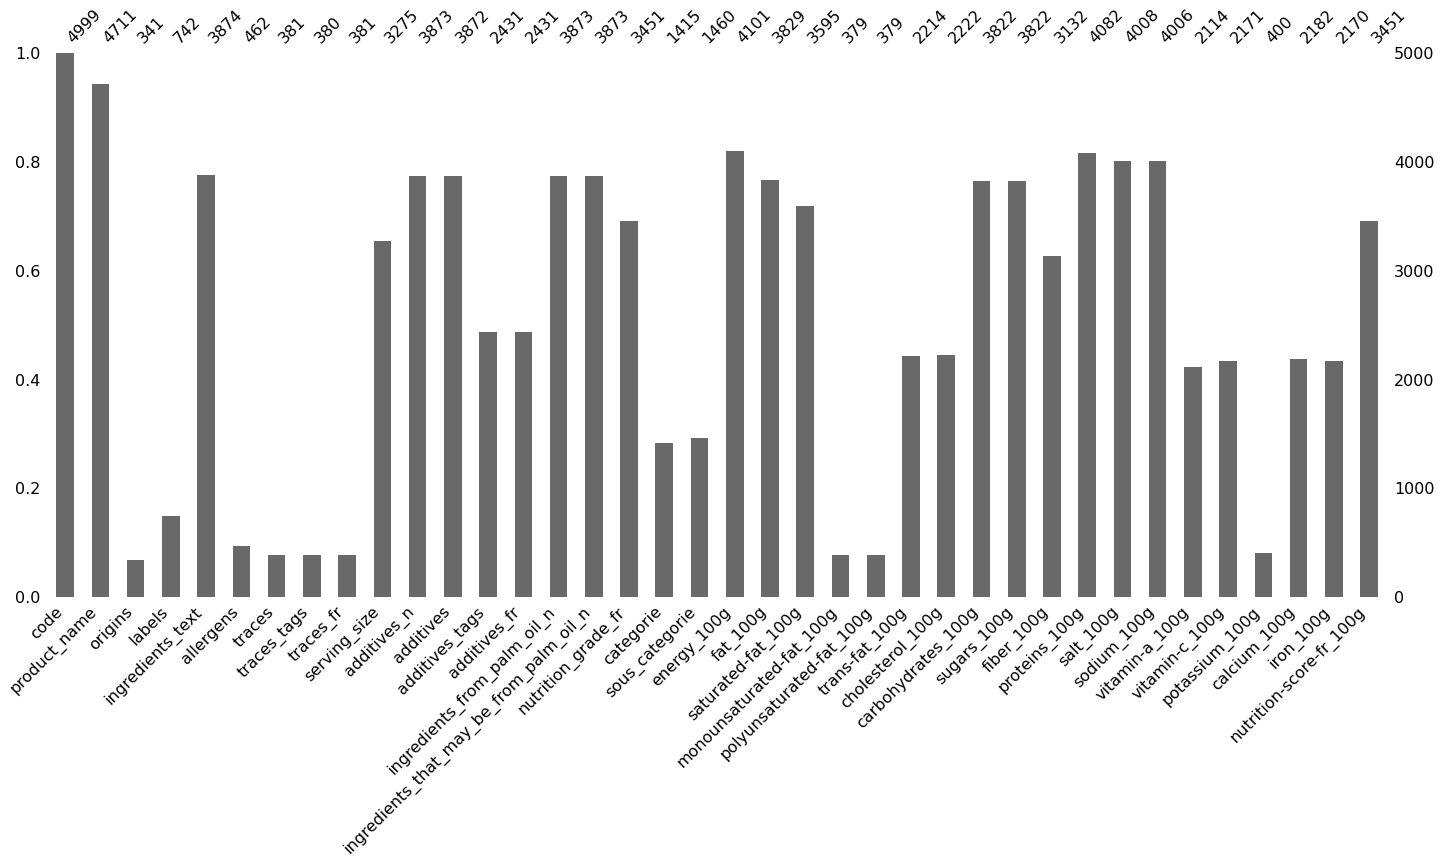

In [7]:
mso.bar(data.sample(5000))

### Suppression de colonnes où il manque trop de valeurs

Au-delà d'une certaine proportion de valeurs manquantes sur une colonne, on supprime la colonne. Le choix de la proportion limite est arbitraire, mais pour cet exemple je vais faire en sorte de conserver les variables 'categorie' et 'sous_categorie' pour la suite.

In [8]:
seuil_colonne = 0.8 # proportion de Nan au-delà de laquelle une colonne sera supprimée

for c in data.columns:
    if data[c].isna().mean() >= seuil_colonne:
        data = data.drop(c, axis=1)

<AxesSubplot:>

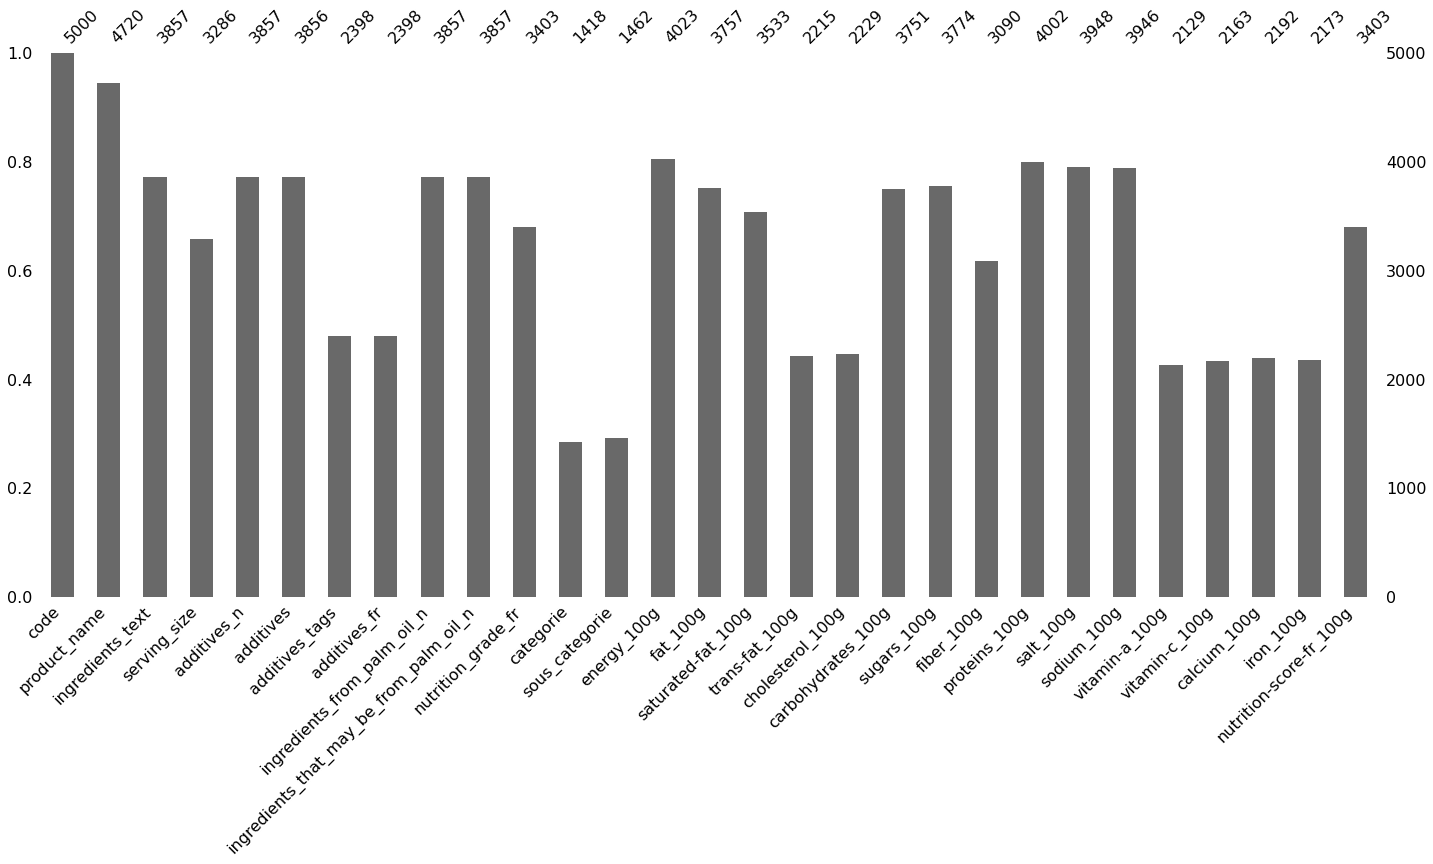

In [9]:
mso.bar(data.sample(5000))

### Suppression de lignes ou il manque trop de valeurs

Nous allons également supprimer les lignes où il manque trop de valeur (plus qu'un certain seuil).

In [10]:
nbre_colonnes = data.shape[1]
nbre_colonnes

29

In [11]:
seuil_ligne = 0.7
nbre_seuil_ligne = math.floor(seuil_ligne * nbre_colonnes)
nbre_seuil_ligne

20

In [12]:
data = data.dropna(thresh=nbre_seuil_ligne)

In [13]:
data.shape

(193724, 29)

In [14]:
data.head()

,code,product_name,ingredients_text,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,categorie,sous_categorie,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
1,0000000004530,Banana Chips Sweetened (Whole),"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,0.0,d,NaN,NaN,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0
2,0000000004559,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,0.0,b,NaN,NaN,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0
3,0000000016087,Organic Salted Nut Mix,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,0.0,d,NaN,NaN,2540.0,57.14,5.36,NaN,NaN,17.86,3.57,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0
7,0000000016124,Organic Muesli,"Org oats, org hemp granola (org oats, evaporat...",64 g (0.5 cup),2.0,[ org-oats -> en:org-oats ] [ oats -> en:oa...,"en:e123,en:e307a","E123 - Amarante,E307a - Tocophérol",0.0,0.0,c,NaN,NaN,1833.0,18.75,4.69,NaN,NaN,57.81,15.62,9.4,14.06,0.13970,0.055,NaN,NaN,0.062,0.00422,7.0
12,0000000016872,Zen Party Mix,"Roasted peanuts (peanuts, peanut or canola oil...",30 g (0.25 cup),1.0,[ roasted-peanuts -> en:roasted-peanuts ] [...,en:e100,E100 - Curcumine,0.0,0.0,d,NaN,NaN,2230.0,36.67,5.00,NaN,NaN,36.67,3.33,6.7,16.67,1.60782,0.633,NaN,NaN,0.133,0.00360,12.0


In [15]:
data.columns

Index(['code', 'product_name', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'categorie', 'sous_categorie', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g'],
      dtype='object')

Pour y voir plus clair dans la suite de cet exemple, je vais considérer moins de variables.

In [16]:
data = data[['product_name','additives_n','ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'categorie', 'sous_categorie', 'energy_100g', 'fat_100g','saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g','salt_100g']]

## Etape 1.2: gérer les valeurs problématiques

Il peut y avoir toutes sorte d'erreur dans un jeu de données: une chaîne de caractère à la place d'une valeur numérique, une valeur manifestement fausse...

On peut commencer par voir les types des éléments des différentes colonnes.

In [17]:
data.dtypes

product_name                                object
additives_n                                float64
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
nutrition_grade_fr                          object
categorie                                   object
sous_categorie                              object
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
dtype: object

Les types sont corrects.

### Traitement des chaînes de caractères

Il y a dans notre jeu de données deux variables essentielles pour notre application, les variables 'categorie' et 'sous_categorie', car ce sont elles qui permettent de proposer un produit de substitution similaire au produit scanné.

In [18]:
data['categorie'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Composite foods', 'Beverages', 'Fish Meat Eggs',
       'Cereals and potatoes', 'Milk and dairy products',
       'Fat and sauces', 'Salty snacks', 'fruits-and-vegetables',
       'sugary-snacks', 'cereals-and-potatoes', 'salty-snacks'],
      dtype=object)

On remarque qu'il y a une catégorie 'Sugary snacks' et une catégorie 'sugary-snacks'. Pour un humain il est clair qu'il doit s'agir en fait d'une seule catégorie, mais pour un ordinateur ce n'est pas clair et il faut uniformiser l'écriture des chaînes de caractères. Cette uniformisation dépend des valeurs se trouvant dans le jeu de données, mais il y a souvent les problèmes récurrents suivants: les majuscules/miniscules, les tirets et les espaces multiples consécutifs. 

On écrit toutes les valeurs de ces variables en minuscule, on remplace les tirets par des espaces et on supprime les espaces multiples. De plus on attribut la catégorie (ou sous-catégorie) 'unknown' pour les valeurs non renseignés (nan).

Bien sûr, dans le context de notre exemple, on aurait besoin de connaître la sous catégorie de chaque produit pour notre application, mais le jeu de données est comme ça... 

In [19]:
data[['categorie', 'sous_categorie']] = data[['categorie', 'sous_categorie']].fillna('unknown')

In [20]:
import re

In [21]:
def uniformisation(mots):
    words = mots.lower() # minuscule
    words = words.replace("-"," ") # remplace les tirets en espace
    words = re.sub(" +"," ", words) # remplace les espaces multiples en un seul espace
    return words

In [22]:
data['categorie'] = data['categorie'].apply(uniformisation)
data['sous_categorie'] = data['sous_categorie'].apply(uniformisation)

In [23]:
data['categorie'].unique()

array(['unknown', 'fruits and vegetables', 'sugary snacks',
       'composite foods', 'beverages', 'fish meat eggs',
       'cereals and potatoes', 'milk and dairy products',
       'fat and sauces', 'salty snacks'], dtype=object)

In [24]:
data['sous_categorie'].unique()

array(['unknown', 'vegetables', 'biscuits and cakes',
       'pizza pies and quiche', 'sweets', 'sweetened beverages',
       'one dish meals', 'soups', 'meat', 'cereals', 'milk and yogurt',
       'fats', 'cheese', 'dressings and sauces', 'chocolate products',
       'sandwich', 'bread', 'nuts', 'legumes', 'breakfast cereals',
       'appetizers', 'non sugared beverages', 'fruit juices', 'eggs',
       'fish and seafood', 'fruits', 'ice cream', 'processed meat',
       'dried fruits', 'pastries', 'dairy desserts', 'potatoes',
       'artificially sweetened beverages', 'alcoholic beverages',
       'fruit nectars', 'salty and fatty products', 'tripe dishes'],
      dtype=object)

### Traitement des valeurs aberrantes

Il est important de vérifier s'il n'y a pas des valeurs manifestement fausses. Par exemple la variable 'nutrition_grade_fr' contient le nutri-score du produit, donc les valeurs possibles de cette variable sont les lettres a, b, c, d, e (ou alors la valeur n'est pas renseignée).

In [25]:
data['nutrition_grade_fr'].unique()

array(['d', 'b', 'c', 'a', 'e', nan], dtype=object)

Il n'y a pas d'erreur évidente pour cette variable (mais il y a peut-être des erreurs de saisie ou de calcul du nutri-score).

Passons aux variables numériques. Dans notre exemple on a des masses (de glucides, de protéines...) pour 100g de produit. Ces variables prennent forcément des valeurs entre 0 et 100. Nous avons aussi des variables qui doivent prendre des valeurs entières positives (comme le nombre d'additifs).

In [26]:
data['additives_n'].unique()

array([ 0.,  2.,  1.,  3.,  5., 10.,  4., 11.,  8.,  7.,  6.,  9., nan,
       13., 18., 22., 19., 17., 25., 12., 21., 14., 16., 20., 24., 23.,
       15., 26., 28., 27., 29., 31.])

In [27]:
data['ingredients_from_palm_oil_n'].unique()

array([ 0.,  1., nan,  2.])

In [28]:
data['ingredients_that_may_be_from_palm_oil_n'].unique()

array([ 0.,  1., nan,  2.,  5.,  3.,  4.,  6.])

Il ni a pas de problème concernant les valeurs devant être des nombres entiers.

In [29]:
data.describe() 
# Les valeurs minimums et maximums de chaque variable nous indiqueront s'il y a des valeurs aberrantes évidentes.

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,193455.000000,193455.000000,193455.000000,1.935190e+05,193145.000000,191215.000000,193169.000000,192081.000000,172927.000000,193290.000000,193611.000000
mean,2.045897,0.021488,0.058649,1.187486e+03,13.032566,4.784504,33.513274,15.141903,2.862856,7.714091,1.732702
std,2.532185,0.146883,0.277829,7.431549e+03,15.824341,7.124726,28.329538,19.713331,4.409138,8.015943,146.818734
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-6.700000,-3.570000,0.000000
25%,0.000000,0.000000,0.000000,4.480000e+02,0.710000,0.000000,7.140000,1.430000,0.000000,1.770000,0.109220
50%,1.000000,0.000000,0.000000,1.196000e+03,7.000000,1.770000,24.620000,5.360000,1.600000,5.560000,0.678180
75%,3.000000,0.000000,0.000000,1.711000e+03,21.430000,7.060000,59.700000,23.330000,3.600000,10.710000,1.400000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,210.000000,209.380000,134.000000,178.000000,100.000000,64312.800000


Il y a manifestement des problèmes...

In [30]:
data[data['fat_100g'] == data['fat_100g'].max()]

,product_name,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,categorie,sous_categorie,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
112681,Premium Extra Virgin Olive Oil,0.0,0.0,0.0,e,unknown,unknown,110579.0,714.29,100.0,NaN,0.0,0.0,0.0,0.0


On va remplacer les valeurs manifestement fausses par des Nan afin qu'elles ne faussent pas l'analyse statistique. Toutes les valeurs de masse pour 100g doivent être comprise entre 0 et 100. Les valeurs d'énergie pour 100g doivent être comprise entre 0 et 900 kcal. 

In [31]:
quantite_100g = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g']
quantite_et_energie_100g = ['energy_100g','fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g']

In [32]:
# On va compter le nombre de valeurs remplacées par Nan
liste = [data[c].isna().value_counts().to_list()[1] for c in quantite_et_energie_100g]
ecart = pd.DataFrame(liste, index =quantite_et_energie_100g, columns=['nbre_de_nan_avant'])

In [33]:
data.loc[(data['energy_100g'] > 900), 'energy_100g'] = np.nan
data.loc[(data['energy_100g'] < 0), 'energy_100g'] = np.nan

In [34]:
for c in quantite_100g:
    data.loc[(data[c] > 100), c] = np.nan
    data.loc[(data[c] < 0), c] = np.nan

In [35]:
liste_apres = [data[c].isna().value_counts().to_list()[1] for c in quantite_et_energie_100g]
ecart['nbre_de_nan_après'] = pd.DataFrame(liste_apres, index =quantite_et_energie_100g, columns=['nbre_de_nan_après'])['nbre_de_nan_après']
ecart['difference']=ecart['nbre_de_nan_après']-ecart['nbre_de_nan_avant']
ecart

,nbre_de_nan_avant,nbre_de_nan_après,difference
energy_100g,205,77730,77525
fat_100g,579,581,2
saturated-fat_100g,2509,2511,2
carbohydrates_100g,555,563,8
sugars_100g,1643,1654,11
fiber_100g,20797,20799,2
proteins_100g,434,435,1
salt_100g,113,161,48


On remarque qu'il y avait beaucoup de valeurs aberrantes pour l'énergie comparé aux autres variables.

# Etape 2: analyse statistique des données

Notre application aura pour but de proposer a l'utilisateur des produits "meilleurs", en un certain sens. Encore faut-il qu'il y ait des produits "meilleurs" dans la base de données de l'application. Imaginons que l'on veuille que l'application propose des produits avec un bon Nutri-Score. Si la base de donnée ne contient quasiment que des produits avec un mauvais Nutri-Score alors l'application risque de ne proposer à l'utilisateur que des produits "un peu moins mauvais" et l'intérêt sera très limité. Nous allons donc dans un premier temps décrire les données afin de voir si on peut produire une application à partir des différentes variables

## Visualisation graphique des données

## Nutri-score

In [36]:
data['nutrition_grade_fr'].value_counts()

d    53372
c    38954
e    36628
a    31061
b    28960
Name: nutrition_grade_fr, dtype: int64

<AxesSubplot:ylabel='nutrition_grade_fr'>

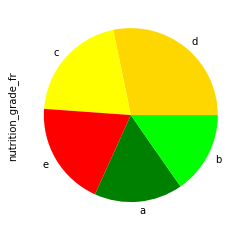

In [37]:
couleur=['#ffd700','#ffff00','#ff0000','#008000', '#00ff00']
data['nutrition_grade_fr'].value_counts().plot(kind='pie', colors=couleur)

[Text(0.5, 1.0, 'Nutri-Score')]

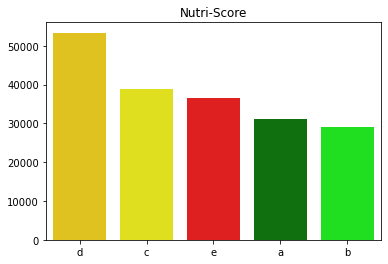

In [38]:
dico_couleur = {'d':'#ffd700','c':'#ffff00','e':'#ff0000','a':'#008000', 'b':'#00ff00'}
comptage = data['nutrition_grade_fr'].value_counts()
sns.barplot(x=comptage.index, y=comptage.values, palette=dico_couleur).set(title='Nutri-Score')

On constate que toutes les valeurs de Nutri-Score sont représentées en grandes quantités, même s'il y a plus de produits avec un mauvais Nutri-Score. Il est donc envisageable que notre application recommande des produit avec un bon Nutri-Score.

<AxesSubplot:xlabel='count', ylabel='categorie'>

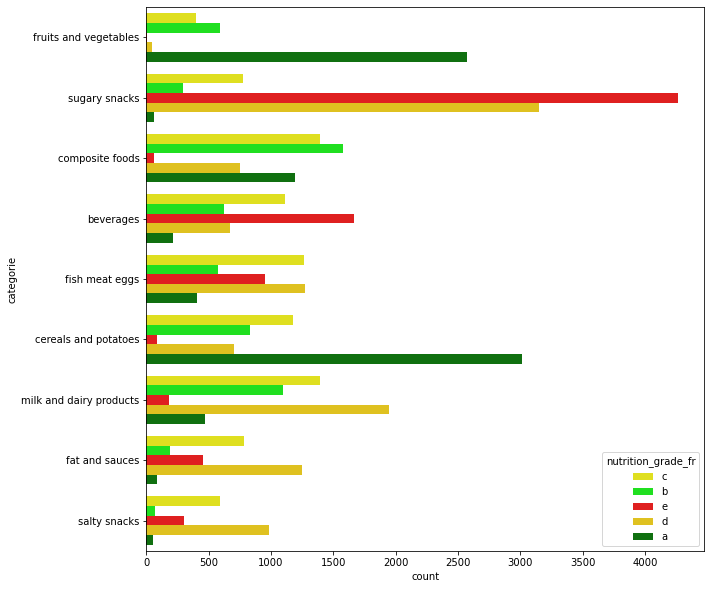

In [55]:
plt.figure(figsize=(10,10))
sns.countplot(y='categorie', hue='nutrition_grade_fr', data=data[data['categorie']!='unknown'], palette=dico_couleur)

<AxesSubplot:xlabel='count', ylabel='sous_categorie'>

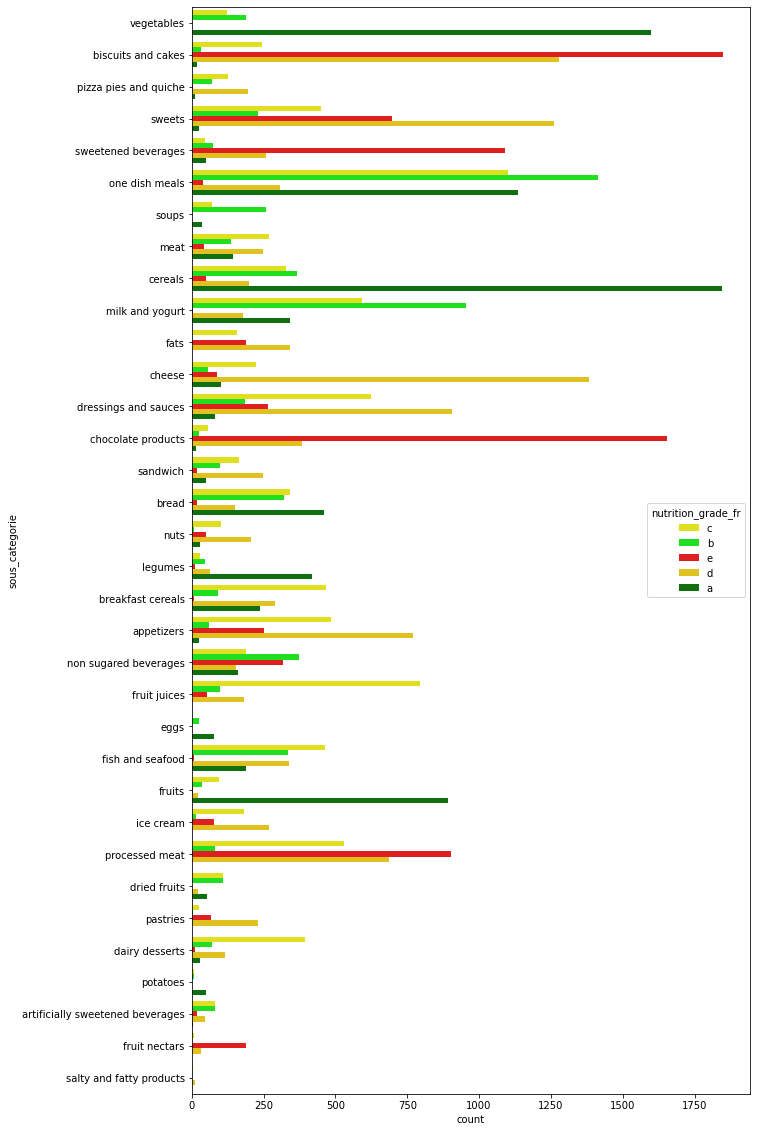

In [56]:
plt.figure(figsize=(10,20))
sns.countplot(y='sous_categorie', hue='nutrition_grade_fr', data=data[data['categorie']!='unknown'], palette=dico_couleur)

## Additifs

In [39]:
data['additives_n'].value_counts()

0.0     64582
1.0     39312
2.0     31480
3.0     19792
4.0     12467
5.0      8617
6.0      5568
7.0      3614
8.0      2575
9.0      1729
10.0     1115
11.0      780
12.0      501
13.0      344
14.0      297
15.0      212
16.0      115
17.0      101
18.0       66
19.0       49
20.0       46
22.0       26
21.0       20
23.0       14
25.0       11
24.0       10
31.0        4
26.0        2
28.0        2
27.0        2
29.0        2
Name: additives_n, dtype: int64

Il n'y aurait pas un grand intérêt à distinguer les produits contenant 29 additifs des produits qui en contiennent 28... 

In [40]:
def classification_nbre_additifs(n):
    if n == 0:
        return 'aucun'
    elif n <= 3 :
        return '1 à 3'
    elif n <= 6:
        return '4 à 6'
    elif n <= 9:
        return '7 à 9'
    else : 
        return '10+'

[Text(0.5, 1.0, "Nombre d'additifs")]

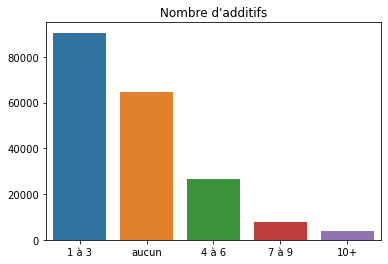

In [41]:
comptage = data['additives_n'].apply(classification_nbre_additifs).value_counts()
sns.barplot(x=comptage.index, y=comptage.values).set(title='Nombre d\'additifs')

Il est envisageable que l'application recommande des produit en fonction du nombre d'additifs qu'ils contiennent suivant le découpage en classe ci-dessus. 

## Huile de palme

<AxesSubplot:title={'center':"Ingrédients contenants de l'huile de palme"}>

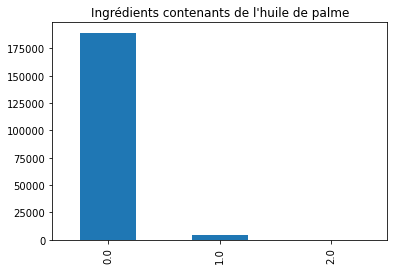

In [42]:
data['ingredients_from_palm_oil_n'].value_counts().plot(kind='bar', title='Ingrédients contenants de l\'huile de palme')

Dans le cas de la présence d'huile de palme, il ne semble pas pertinent de s'intéresser au nombre exact d'ingrédient contenant de l'huile de palme, mais seulement de répondre à la question: y-a-t'il, oui ou non, des ingrédients à base d'huile de palme?

In [43]:
data['ingredients_that_may_be_from_palm_oil_n'].value_counts()

0.0    183855
1.0      8181
2.0      1139
3.0       238
4.0        38
5.0         3
6.0         1
Name: ingredients_that_may_be_from_palm_oil_n, dtype: int64

In [44]:
def classification_nbre_palm_oil_maybe(n):
    if n == 0:
        return 'aucun'
    elif n == 1 :
        return '1'
    elif n == 2:
        return '2'
    else : 
        return '3 à 6'

[Text(0.5, 1.0, "Ingrédients pouvant contenir de l'huile de palme")]

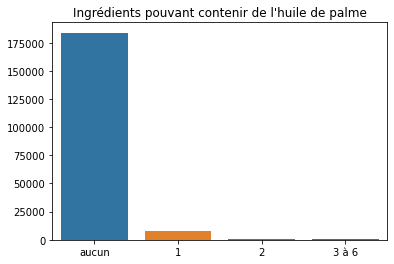

In [45]:
comptage = data['ingredients_that_may_be_from_palm_oil_n'].apply(classification_nbre_palm_oil_maybe).value_counts()
sns.barplot(x=comptage.index, y=comptage.values).set(title='Ingrédients pouvant contenir de l\'huile de palme')

Dans le cas de la présence potentielle d'huile de palme, il ne semble pas pertinent de s'intéresser au nombre exact d'ingrédient pouvant contenir de l'huile de palme, mais seulement de répondre à la question: y-a-t'il, oui ou non, des ingrédients susceptible de contenir de l'huile de palme?

Finalement, concernant la présence d'huile de palme, il serait plus pertinant d'utiliser une seule variable prennant trois valeurs possibles: oui, non, peut-être.

## Valeurs nutritionnelles pour 100g

### Analyse univariée

In [46]:
data[quantite_et_energie_100g].describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,77730.000000,193143.000000,191213.000000,193161.000000,192070.000000,172925.000000,193289.000000,193563.000000
mean,392.811660,13.027035,4.782539,33.508900,15.140605,2.861899,7.714150,1.272185
std,245.140324,15.721609,7.098578,28.320937,19.708337,4.388943,8.015923,4.004423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,192.000000,0.710000,0.000000,7.140000,1.430000,0.000000,1.770000,0.109220
50%,349.000000,7.000000,1.770000,24.620000,5.360000,1.600000,5.560000,0.678180
75%,575.000000,21.430000,7.060000,59.700000,23.330000,3.600000,10.710000,1.399540
max,900.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [47]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
# Un point rouge indiquera la moyenne dans les boxplot

Text(0.5, 1.0, 'glucides pour 100g')

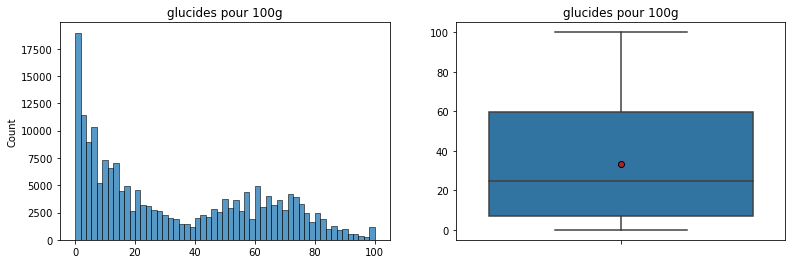

In [48]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
sns.histplot(data=data, x='carbohydrates_100g').set(xlabel='')
plt.title('glucides pour 100g')
plt.subplot(1,2,2)
sns.boxplot(data=data[['carbohydrates_100g']], showmeans=True, meanprops=meanprops).set(xticklabels=[])
plt.title('glucides pour 100g')

<AxesSubplot:>

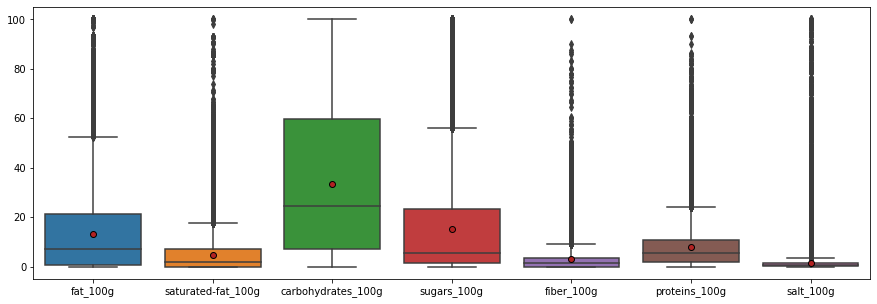

In [49]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data[quantite_100g], showmeans=True, meanprops=meanprops)

### Analyse bivariée

<AxesSubplot:xlabel='fat_100g', ylabel='categorie'>

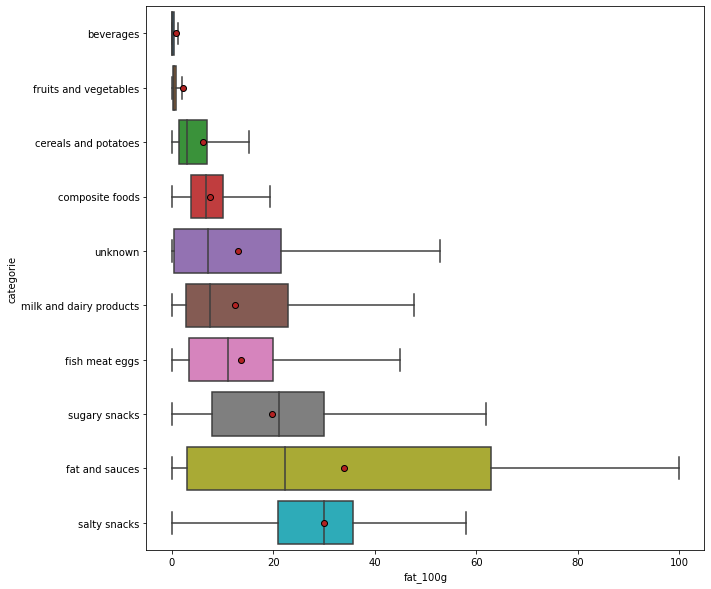

In [52]:
ordre_fat = data.groupby('categorie')['fat_100g'].median().sort_values().index

plt.figure(figsize=(10,10))
sns.boxplot(x="fat_100g",y="categorie", showfliers=False, showmeans=True, meanprops=meanprops,
            orient='h', order=ordre_fat, data=data)

## Effectuer des tests statistiques

# Exemple 2: analyse statistique de données destinées à entraîner un modèle de machine learning

In [57]:
train = pd.read_csv('data/titanic_train.csv')
test = pd.read_csv("data/titanic_test.csv")